In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from pydataset import data

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


In [2]:
import graphviz
from graphviz import Graph

In [3]:
def split(df, stratify_by=None):
    """
    Crude train, validate, test split
    To stratify, send in a column name for the stratify_by argument
    """

    if stratify_by == None:
        train, test = train_test_split(df, test_size=.2, random_state=123)
        train, validate = train_test_split(train, test_size=.3, random_state=123)
    else:
        train, test = train_test_split(df, test_size=.2, random_state=123, stratify=df[stratify_by])
        train, validate = train_test_split(train, test_size=.3, random_state=123, stratify=train[stratify_by])

    return train, validate, test

# Modelling: Decision Tree

In [4]:
df = pd.read_csv('titanic_df.csv')

In [5]:
df.head()

,Unnamed: 0,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,0,3,male,22.0,1,0,7.2500,S,Third,NaN,Southampton,0
1,1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0
2,2,2,1,3,female,26.0,0,0,7.9250,S,Third,NaN,Southampton,1
3,3,3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0
4,4,4,0,3,male,35.0,0,0,8.0500,S,Third,NaN,Southampton,1


In [6]:
dummy1_df = pd.get_dummies(df[['embark_town']],drop_first=True)
dummy2_df = pd.get_dummies(df[['class']],drop_first=True)
df["is_female"] = (df.sex == "female")

In [7]:
df = pd.concat([df,dummy1_df,dummy2_df], axis=1)

df = df.drop(columns=['Unnamed: 0','passenger_id','age','sex', 'pclass','class', 'embarked','embark_town','deck','sibsp','parch'])


In [8]:
df.dropna(inplace=True)

In [9]:
df.head()

,survived,fare,alone,is_female,embark_town_Queenstown,embark_town_Southampton,class_Second,class_Third
0,0,7.2500,0,False,0,1,0,1
1,1,71.2833,0,True,0,0,0,0
2,1,7.9250,1,True,0,1,0,1
3,1,53.1000,0,True,0,1,0,0
4,0,8.0500,1,False,0,1,0,1


In [10]:
train, validate, test = split(df, stratify_by="survived")

In [11]:
train.shape, validate.shape, test.shape

((498, 8), (214, 8), (179, 8))

In [12]:
train.columns, validate.columns

(Index(['survived', 'fare', 'alone', 'is_female', 'embark_town_Queenstown',
        'embark_town_Southampton', 'class_Second', 'class_Third'],
       dtype='object'),
 Index(['survived', 'fare', 'alone', 'is_female', 'embark_town_Queenstown',
        'embark_town_Southampton', 'class_Second', 'class_Third'],
       dtype='object'))

In [13]:
# Setup our X inputs and y target variable for each split
X_train = train.drop(columns=['survived'])
y_train = train.survived # labeled data == supervise algorithm

X_validate = validate.drop(columns=['survived'])
y_validate = validate.survived

X_test = test.drop(columns=['survived'])
y_test = test.survived

In [14]:
df.survived.value_counts()

0    549
1    342
Name: survived, dtype: int64

## Exercise 1. 
### What is your baseline prediction? What is your baseline accuracy? 


In [15]:
train["most_frequent"] = 0
baseline_accuracy = (train.survived == train.most_frequent).mean()
print(f'My baseline prediction is survived = 0')
print(f'My baseline accuracy is: {baseline_accuracy:.2%}')

My baseline prediction is survived = 0
My baseline accuracy is: 61.65%


## Exercise 2.
### Fit the decision tree classifier to your training sample and transform (i.e. make predictions on the training sample)

In [16]:
clf = DecisionTreeClassifier(max_depth=2, random_state=123)

In [17]:
# fitting == training the model
clf = clf.fit(X_train, y_train)
clf

DecisionTreeClassifier(max_depth=2, random_state=123)

In [18]:
y_pred = clf.predict(X_train)
y_pred[0:10]

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 1])

In [19]:
y_pred_proba = clf.predict_proba(X_train)
y_pred_proba[0:5]

array([[0.68644068, 0.31355932],
       [0.68644068, 0.31355932],
       [0.68644068, 0.31355932],
       [0.04255319, 0.95744681],
       [0.04255319, 0.95744681]])

## Exercise 3 & 4.
### Evaluate your in-sample results using the model score, confusion matrix, and classification report.
### Compute: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

In [20]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.80


In [21]:
print(confusion_matrix(y_train, y_pred))

[[265  42]
 [ 58 133]]


In [22]:
labels = sorted(y_train.unique())

pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)

,0,1
0,265,42
1,58,133


In [23]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       307
           1       0.76      0.70      0.73       191

    accuracy                           0.80       498
   macro avg       0.79      0.78      0.78       498
weighted avg       0.80      0.80      0.80       498



In [24]:
[tn,fp],[fn, tp] = confusion_matrix(y_train, y_pred)

In [25]:
tp, tn, fp, fn

(133, 265, 42, 58)

In [26]:
tpr = (tp / (tp+fn))
fnr = (fn / (fn+tp))
tnr = (tn / (tn+fp))
fpr = (fp / (tn+fp))

print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))
print(f'The True Positive Rate is: {tpr:.2%}')
print(f'The False Positive Rate is: {fpr:.2%}')
print(f'The True Negative Rate is: {tnr:.2%}')
print(f'The False Negative Rate is: {fnr:.2%}')

Accuracy of Decision Tree classifier on training set: 0.80
The True Positive Rate is: 69.63%
The False Positive Rate is: 13.68%
The True Negative Rate is: 86.32%
The False Negative Rate is: 30.37%


In [27]:
dot_data = export_graphviz(clf, feature_names= X_train.columns, rounded=True, filled=True, out_file=None)
graph = graphviz.Source(dot_data) 

graph.render('titanic_decision_tree_2', view=True, format='pdf')

'titanic_decision_tree_2.pdf'

## Exercise 5.
### Run through steps 2-4 using a different max_depth value

In [28]:
clf = DecisionTreeClassifier(max_depth=4, random_state=123)

In [29]:
# fitting == training the model
clf = clf.fit(X_train, y_train)
clf

DecisionTreeClassifier(max_depth=4, random_state=123)

In [30]:
y_pred = clf.predict(X_train)
y_pred[0:10]

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0])

In [31]:
y_pred_proba = clf.predict_proba(X_train)
y_pred_proba[0:5]

array([[0.65909091, 0.34090909],
       [0.65909091, 0.34090909],
       [0.65909091, 0.34090909],
       [0.04878049, 0.95121951],
       [0.        , 1.        ]])

In [32]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.83


In [33]:
print(confusion_matrix(y_train, y_pred))

[[277  30]
 [ 57 134]]


In [34]:
labels = sorted(y_train.unique())

pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)

,0,1
0,277,30
1,57,134


In [35]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86       307
           1       0.82      0.70      0.75       191

    accuracy                           0.83       498
   macro avg       0.82      0.80      0.81       498
weighted avg       0.82      0.83      0.82       498



In [36]:
[tn,fp],[fn, tp] = confusion_matrix(y_train, y_pred)

In [37]:
tp, tn, fp, fn

(134, 277, 30, 57)

In [38]:
tpr = (tp / (tp+fn))
fnr = (fn / (fn+tp))
tnr = (tn / (tn+fp))
fpr = (fp / (tn+fp))


print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))
print(f'The True Positive Rate is: {tpr:.2%}')
print(f'The False Positive Rate is: {fpr:.2%}')
print(f'The True Negative Rate is: {tnr:.2%}')
print(f'The False Negative Rate is: {fnr:.2%}')
                        

Accuracy of Decision Tree classifier on training set: 0.83
The True Positive Rate is: 70.16%
The False Positive Rate is: 9.77%
The True Negative Rate is: 90.23%
The False Negative Rate is: 29.84%


In [39]:

dot_data = export_graphviz(clf, feature_names= X_train.columns, rounded=True, filled=True, out_file=None)
graph = graphviz.Source(dot_data) 

graph.render('titanic_decision_tree_4', view=True, format='pdf')

'titanic_decision_tree_4.pdf'

## Exercise 6.
### Which model performs better on your in-sample data?

- **In this example max_depth of 4 appears to be a better fit than a max_depth of 2**

## Exercise 7.
### Which model performs best on your out-of-sample data, the validate set?

In [40]:
clf = DecisionTreeClassifier(max_depth=2, random_state=123)
clf = clf.fit(X_train, y_train)

In [41]:
clf.score(X_validate, y_validate)

0.7616822429906542

In [42]:
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
     .format(clf.score(X_validate, y_validate)))

Accuracy of Decision Tree classifier on validate set: 0.76


In [43]:
y_pred = clf.predict(X_validate)
y_pred[0:3]

array([1, 0, 0])

In [44]:
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.83      0.81       132
           1       0.70      0.66      0.68        82

    accuracy                           0.76       214
   macro avg       0.75      0.74      0.74       214
weighted avg       0.76      0.76      0.76       214



- Max depth changed to 4

In [45]:
clf = DecisionTreeClassifier(max_depth=4, random_state=123)
clf = clf.fit(X_train, y_train)

In [46]:
clf.score(X_validate, y_validate)

0.7850467289719626

In [47]:
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
     .format(clf.score(X_validate, y_validate)))

Accuracy of Decision Tree classifier on validate set: 0.79


In [48]:
y_pred = clf.predict(X_validate)
y_pred[0:3]

array([0, 0, 0])

In [49]:
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.87      0.83       132
           1       0.76      0.65      0.70        82

    accuracy                           0.79       214
   macro avg       0.78      0.76      0.77       214
weighted avg       0.78      0.79      0.78       214



- **The model with max_depth of 4 still appears like a better model than one with max_depth of 2**

In [50]:
validate.head()

,survived,fare,alone,is_female,embark_town_Queenstown,embark_town_Southampton,class_Second,class_Third
610,0,31.2750,0,True,0,1,0,1
424,0,20.2125,0,False,0,1,0,1
568,0,7.2292,1,False,0,0,0,1
334,1,133.6500,0,True,0,1,0,0
101,0,7.8958,1,False,0,1,0,1


# Random Forests / Bootstrapping

## Exercise 1. 
### Fit the Random Forest classifier to your training sample and transform (i.e. make predictions on the training sample) setting the random_state accordingly and setting min_samples_leaf = 1 and max_depth = 10

In [51]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=1,
                            n_estimators=100,
                            max_depth=100, 
                            random_state=1349)

In [52]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=100, random_state=1349)

In [53]:
print(rf.feature_importances_)

[0.47647669 0.03787581 0.33577905 0.01236716 0.03102528 0.02063261
 0.0858434 ]


In [54]:
y_pred = rf.predict(X_train)

In [55]:
y_pred_proba = rf.predict_proba(X_train)

## Exercise 2 & 3.
### Evaluate your results using the model score, confusion matrix, and classification report.
### Print and clearly label the following: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.



In [56]:
[tn,fp],[fn, tp] = confusion_matrix(y_train, y_pred)

In [57]:
tp, tn, fp, fn

(166, 301, 6, 25)

In [58]:
tpr = (tp / (tp+fn))
fnr = (fn / (fn+tp))
tnr = (tn / (tn+fp))
fpr = (fp / (tn+fp))
                        

In [59]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))
print(f'\nThe confusion matrix:\n {confusion_matrix(y_train, y_pred)}\n')
print(f'Classificaiton Report:\n{classification_report(y_train, y_pred)}\n')
print(f'The True Positive Rate is: {tpr:.2%}')
print(f'The False Positive Rate is: {fpr:.2%}')
print(f'The True Negative Rate is: {tnr:.2%}')
print(f'The False Negative Rate is: {fnr:.2%}')

Accuracy of random forest classifier on training set: 0.94

The confusion matrix:
 [[301   6]
 [ 25 166]]

Classificaiton Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       307
           1       0.97      0.87      0.91       191

    accuracy                           0.94       498
   macro avg       0.94      0.92      0.93       498
weighted avg       0.94      0.94      0.94       498


The True Positive Rate is: 86.91%
The False Positive Rate is: 1.95%
The True Negative Rate is: 98.05%
The False Negative Rate is: 13.09%


In [60]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_validate, y_validate)))

Accuracy of random forest classifier on test set: 0.79


## Exercise 4.
### Run through steps increasing your min_samples_leaf and decreasing your max_depth.

In [61]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=10, 
                            random_state=1349)

In [62]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, random_state=1349)

In [63]:
print(rf.feature_importances_)

[0.33329946 0.0431314  0.44759353 0.01199929 0.03643056 0.02571195
 0.10183381]


In [64]:
y_pred = rf.predict(X_train)

In [65]:
y_pred_proba = rf.predict_proba(X_train)

In [66]:
[tn,fp],[fn, tp] = confusion_matrix(y_train, y_pred)

In [67]:
tp, tn, fp, fn

(147, 287, 20, 44)

In [68]:
tpr = (tp / (tp+fn))
fnr = (fn / (fn+tp))
tnr = (tn / (tn+fp))
fpr = (fp / (tn+fp))
                        

In [69]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))
print(f'\nThe confusion matrix:\n {confusion_matrix(y_train, y_pred)}\n')
print(f'Classificaiton Report:\n{classification_report(y_train, y_pred)}\n')
print(f'The True Positive Rate is: {tpr:.2%}')
print(f'The False Positive Rate is: {fpr:.2%}')
print(f'The True Negative Rate is: {tnr:.2%}')
print(f'The False Negative Rate is: {fnr:.2%}')

Accuracy of random forest classifier on training set: 0.87

The confusion matrix:
 [[287  20]
 [ 44 147]]

Classificaiton Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       307
           1       0.88      0.77      0.82       191

    accuracy                           0.87       498
   macro avg       0.87      0.85      0.86       498
weighted avg       0.87      0.87      0.87       498


The True Positive Rate is: 76.96%
The False Positive Rate is: 6.51%
The True Negative Rate is: 93.49%
The False Negative Rate is: 23.04%


In [70]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_validate, y_validate)))

Accuracy of random forest classifier on test set: 0.79


## Exercise 5.
### What are the differences in the evaluation metrics? Which performs better on your in-sample data? Why?

**My second random forest worked out better with min sample leaf set to 3 and max_depth set to 10**
Accuracy - All of the total correct guesses out of all obersvations
TPR - Sensitivity: Recall for positives


## Exercise 6.
### After making a few models, which one has the best performance (or closest metrics) on both train and validate?

In [71]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=2,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=1349)

In [72]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, min_samples_leaf=2, random_state=1349)

In [73]:
print(rf.feature_importances_)

[0.17432844 0.05342746 0.55135908 0.01568971 0.0328546  0.02470818
 0.14763251]


In [74]:
y_pred = rf.predict(X_train)

In [75]:
y_pred_proba = rf.predict_proba(X_train)

In [76]:
[tn,fp],[fn, tp] = confusion_matrix(y_train, y_pred)

In [77]:
tp, tn, fp, fn

(114, 292, 15, 77)

In [78]:
tpr = (tp / (tp+fn))
fnr = (fn / (fn+tp))
tnr = (tn / (tn+fp))
fpr = (fp / (tn+fp))
                        

In [79]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))
print(f'\nThe confusion matrix:\n {confusion_matrix(y_train, y_pred)}\n')
print(f'Classificaiton Report:\n{classification_report(y_train, y_pred)}\n')
print(f'The True Positive Rate is: {tpr:.2%}')
print(f'The False Positive Rate is: {fpr:.2%}')
print(f'The True Negative Rate is: {tnr:.2%}')
print(f'The False Negative Rate is: {fnr:.2%}')

Accuracy of random forest classifier on training set: 0.82

The confusion matrix:
 [[292  15]
 [ 77 114]]

Classificaiton Report:
              precision    recall  f1-score   support

           0       0.79      0.95      0.86       307
           1       0.88      0.60      0.71       191

    accuracy                           0.82       498
   macro avg       0.84      0.77      0.79       498
weighted avg       0.83      0.82      0.81       498


The True Positive Rate is: 59.69%
The False Positive Rate is: 4.89%
The True Negative Rate is: 95.11%
The False Negative Rate is: 40.31%


In [80]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_validate, y_validate)))

Accuracy of random forest classifier on test set: 0.80


In [81]:
X_train.head()

,fare,alone,is_female,embark_town_Queenstown,embark_town_Southampton,class_Second,class_Third
583,40.1250,1,False,0,0,0,0
165,20.5250,0,False,0,1,0,1
50,39.6875,0,False,0,1,0,1
259,26.0000,0,True,0,1,1,0
306,110.8833,1,True,0,0,0,0


# kNN

## Exercise 1.
### Fit a K-Nearest Neighbors classifier to your training sample and transform (i.e. make predictions on the training sample)

In [82]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [83]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

## Exercise 2 & 3.
### Evaluate your results using the model score, confusion matrix, and classification report.
### Print and clearly label the following: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

In [84]:
y_pred = knn.predict(X_train)

In [85]:
y_pred_proba = knn.predict_proba(X_train)

In [86]:
[tn,fp],[fn, tp] = confusion_matrix(y_train, y_pred)

In [87]:
tpr = (tp / (tp+fn))
fnr = (fn / (fn+tp))
tnr = (tn / (tn+fp))
fpr = (fp / (tn+fp))

In [88]:

print('Accuracy of KNN classifier on training set n_neighbors set to 5: {:.2f}'
     .format(knn.score(X_train, y_train)))
print(f'The confusion matrix:\n {confusion_matrix(y_train, y_pred)}\n')
print(f'Classificaiton Report:\n{classification_report(y_train, y_pred)}\n')
print(f'The True Positive Rate is: {tpr:.2%}')
print(f'The False Positive Rate is: {fpr:.2%}')
print(f'The True Negative Rate is: {tnr:.2%}')
print(f'The False Negative Rate is: {fnr:.2%}')


Accuracy of KNN classifier on training set n_neighbors set to 5: 0.82
The confusion matrix:
 [[270  37]
 [ 53 138]]

Classificaiton Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       307
           1       0.79      0.72      0.75       191

    accuracy                           0.82       498
   macro avg       0.81      0.80      0.81       498
weighted avg       0.82      0.82      0.82       498


The True Positive Rate is: 72.25%
The False Positive Rate is: 12.05%
The True Negative Rate is: 87.95%
The False Negative Rate is: 27.75%


## Exercise 4.
### Run through steps 2-4 setting k to 10

In [89]:
knn2 = KNeighborsClassifier(n_neighbors=10, weights='uniform')

In [90]:
knn2.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [91]:
y_pred = knn2.predict(X_train)

In [92]:
y_pred_proba = knn2.predict_proba(X_train)

In [93]:
[tn,fp],[fn, tp] = confusion_matrix(y_train, y_pred)

In [94]:
tpr = (tp / (tp+fn))
fnr = (fn / (fn+tp))
tnr = (tn / (tn+fp))
fpr = (fp / (tn+fp))

In [95]:

print('Accuracy of KNN classifier on training set n_neighbors set to 10: {:.2f}\n'
     .format(knn2.score(X_train, y_train)))
print(f'The confusion matrix:\n {confusion_matrix(y_train, y_pred)}\n')
print(f'Classificaiton Report:\n{classification_report(y_train, y_pred)}\n')
print(f'The True Positive Rate is: {tpr:.2%}')
print(f'The False Positive Rate is: {fpr:.2%}')
print(f'The True Negative Rate is: {tnr:.2%}')
print(f'The False Negative Rate is: {fnr:.2%}')


Accuracy of KNN classifier on training set n_neighbors set to 10: 0.79

The confusion matrix:
 [[273  34]
 [ 71 120]]

Classificaiton Report:
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       307
           1       0.78      0.63      0.70       191

    accuracy                           0.79       498
   macro avg       0.79      0.76      0.77       498
weighted avg       0.79      0.79      0.78       498


The True Positive Rate is: 62.83%
The False Positive Rate is: 11.07%
The True Negative Rate is: 88.93%
The False Negative Rate is: 37.17%


## Exercise 5.
### Run through steps 2-4 setting k to 20

In [96]:
knn3 = KNeighborsClassifier(n_neighbors=20, weights='uniform')

In [97]:
knn3.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=20)

In [98]:
y_pred = knn3.predict(X_train)

In [99]:
y_pred_proba = knn3.predict_proba(X_train)

In [100]:
[tn,fp],[fn, tp] = confusion_matrix(y_train, y_pred)

In [101]:
tpr = (tp / (tp+fn))
fnr = (fn / (fn+tp))
tnr = (tn / (tn+fp))
fpr = (fp / (tn+fp))

In [102]:

print('Accuracy of KNN classifier on training set n_neighbors set to 20: {:.2f}\n'
     .format(knn3.score(X_train, y_train)))
print(f'The confusion matrix:\n {confusion_matrix(y_train, y_pred)}\n')
print(f'Classificaiton Report:\n{classification_report(y_train, y_pred)}\n')
print(f'The True Positive Rate is: {tpr:.2%}')
print(f'The False Positive Rate is: {fpr:.2%}')
print(f'The True Negative Rate is: {tnr:.2%}')
print(f'The False Negative Rate is: {fnr:.2%}')


Accuracy of KNN classifier on training set n_neighbors set to 20: 0.74

The confusion matrix:
 [[265  42]
 [ 86 105]]

Classificaiton Report:
              precision    recall  f1-score   support

           0       0.75      0.86      0.81       307
           1       0.71      0.55      0.62       191

    accuracy                           0.74       498
   macro avg       0.73      0.71      0.71       498
weighted avg       0.74      0.74      0.73       498


The True Positive Rate is: 54.97%
The False Positive Rate is: 13.68%
The True Negative Rate is: 86.32%
The False Negative Rate is: 45.03%


## Exercise 6. 
### What are the differences in the evaluation metrics? Which performs better on your in-sample data? Why?

- Precision, recall, f1-sore, and accuracy all seemed higher with a lower k number. With a lower K, data is more sensitive to the specificity of training data.

## Exercise 7.
### Which model performs best on our out-of-sample data from validate?

In [103]:
print('Accuracy of KNN classifier on training set n_neighbors set to 5: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of KNN classifier on test set with n_neighbors set to 5: {:.2f}\n'
     .format(knn.score(X_validate, y_validate)))
print('Accuracy of KNN classifier on training set n_neighbors set to 10: {:.2f}'
     .format(knn2.score(X_train, y_train)))
print('Accuracy of KNN classifier on test set with n_neighbors set to 10: {:.2f}\n'
     .format(knn2.score(X_validate, y_validate)))
print('Accuracy of KNN classifier on training set n_neighbors set to 20: {:.2f}'
     .format(knn3.score(X_train, y_train)))
print('Accuracy of KNN classifier on test set with n_neighbors set to 20: {:.2f}'
     .format(knn3.score(X_validate, y_validate)))


Accuracy of KNN classifier on training set n_neighbors set to 5: 0.82
Accuracy of KNN classifier on test set with n_neighbors set to 5: 0.75

Accuracy of KNN classifier on training set n_neighbors set to 10: 0.79
Accuracy of KNN classifier on test set with n_neighbors set to 10: 0.72

Accuracy of KNN classifier on training set n_neighbors set to 20: 0.74
Accuracy of KNN classifier on test set with n_neighbors set to 20: 0.70


The model with k set to 20 performed the best, there was much less variance in the in-sample and out-of-sample accuracies

# Logistic Regression

In [104]:
from sklearn.linear_model import LogisticRegression

## Exercise 1.
### Create a model that includes age in addition to fare and pclass. Does this model perform better than your baseline?

In [105]:
# import new titanic data, keep age, fare, pclass
df2 = pd.read_csv('titanic_df.csv')

In [106]:
list(df2.columns)

['Unnamed: 0',
 'passenger_id',
 'survived',
 'pclass',
 'sex',
 'age',
 'sibsp',
 'parch',
 'fare',
 'embarked',
 'class',
 'deck',
 'embark_town',
 'alone']

In [107]:
dummy_df2 = pd.get_dummies(df2[['sex']],drop_first=True)

In [108]:
df2 = pd.concat([df2,dummy_df2], axis=1)

In [109]:
list(df2.columns)

['Unnamed: 0',
 'passenger_id',
 'survived',
 'pclass',
 'sex',
 'age',
 'sibsp',
 'parch',
 'fare',
 'embarked',
 'class',
 'deck',
 'embark_town',
 'alone',
 'sex_male']

In [110]:
df2 = df2.drop(columns=['Unnamed: 0',
 'passenger_id',
 'embarked',
 'class',
 'deck',
 'alone', 'sex', 'embarked'])

In [111]:
df2.dropna(inplace=True)

In [112]:
train, validate, test = split(df2, stratify_by="survived")

In [113]:
train.shape, validate.shape, test.shape

((398, 8), (171, 8), (143, 8))

In [114]:
list(df2.columns)

['survived',
 'pclass',
 'age',
 'sibsp',
 'parch',
 'fare',
 'embark_town',
 'sex_male']

# Model 1

In [115]:
X_train2 = train.drop(columns=['survived', 'sibsp', 'parch', 'embark_town', 'sex_male'])
y_train = train.survived 

X_validate2 = validate.drop(columns=['survived', 'sibsp', 'parch', 'embark_town', 'sex_male'])
y_validate = validate.survived

X_test2 = test.drop(columns=['survived', 'sibsp', 'parch', 'embark_town', 'sex_male'])
y_test = test.survived

In [116]:
train["most_frequent"] = 0
baseline_accuracy = (train.survived == train.most_frequent).mean()
print(f'My baseline prediction is survived = 0')
print(f'My baseline accuracy is: {baseline_accuracy:.2%}')

My baseline prediction is survived = 0
My baseline accuracy is: 59.55%


In [117]:
logit = LogisticRegression(C=1, random_state=123, intercept_scaling=1, solver='lbfgs')

In [118]:
logit.fit(X_train2, y_train)

LogisticRegression(C=1, random_state=123)

In [119]:
print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

Coefficient: 
 [[-1.18041689 -0.0377487   0.0040374 ]]
Intercept: 
 [3.15727557]


In [120]:
y_pred = logit.predict(X_train2)

In [121]:
y_pred_proba = logit.predict_proba(X_train2)

In [122]:
print(f'The features used are : {list(X_train2.columns)}\n\n')
print('Accuracy of Logistic Regression classifier on training set: {:.2f}\n'
     .format(logit.score(X_train2, y_train)))
print(f'The confusion matrix:\n {confusion_matrix(y_train, y_pred)}\n')
print(f'Classificaiton Report:\n {classification_report(y_train, y_pred)}')

The features used are : ['pclass', 'age', 'fare']


Accuracy of Logistic Regression classifier on training set: 0.72

The confusion matrix:
 [[200  37]
 [ 74  87]]

Classificaiton Report:
               precision    recall  f1-score   support

           0       0.73      0.84      0.78       237
           1       0.70      0.54      0.61       161

    accuracy                           0.72       398
   macro avg       0.72      0.69      0.70       398
weighted avg       0.72      0.72      0.71       398



## Exercise 2.
### Include sex in your model as well. Note that you'll need to encode or create a dummy variable of this feature before including it in a model.



# Model 2

In [123]:
X_train3 = train.drop(columns=['survived', 'sibsp', 'parch', 'embark_town', 'most_frequent'])

X_validate3 = validate.drop(columns=['survived', 'sibsp', 'parch', 'embark_town'])

X_test3 = test.drop(columns=['survived', 'sibsp', 'parch', 'embark_town'])


In [124]:
logit.fit(X_train3, y_train)

LogisticRegression(C=1, random_state=123)

In [125]:
X_train3.head()

,pclass,age,fare,sex_male
450,2,36.0,27.75,1
543,2,32.0,26.00,1
157,3,30.0,8.05,1
462,1,47.0,38.50,1
397,2,46.0,26.00,1


In [126]:
print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

Coefficient: 
 [[-1.32007480e+00 -3.12875684e-02  1.40193876e-03 -2.40079403e+00]]
Intercept: 
 [4.77089023]


In [127]:
y_pred = logit.predict(X_train3)

In [128]:
y_pred_proba = logit.predict_proba(X_train3)

In [129]:
print(f'The features used are : {list(X_train3.columns)}\n\n')
print('Accuracy of Logistic Regression classifier on training set: {:.2f}\n'
     .format(logit.score(X_train3, y_train)))
print(f'The confusion matrix:\n {confusion_matrix(y_train, y_pred)}\n')
print(f'Classificaiton Report:\n {classification_report(y_train, y_pred)}')

The features used are : ['pclass', 'age', 'fare', 'sex_male']


Accuracy of Logistic Regression classifier on training set: 0.80

The confusion matrix:
 [[201  36]
 [ 45 116]]

Classificaiton Report:
               precision    recall  f1-score   support

           0       0.82      0.85      0.83       237
           1       0.76      0.72      0.74       161

    accuracy                           0.80       398
   macro avg       0.79      0.78      0.79       398
weighted avg       0.80      0.80      0.80       398



## Exercise 3.
### Try out other combinations of features and models.

# Model 3

In [130]:
X_train4 = train.drop(columns=['survived', 'fare', 'parch', 'embark_town', 'most_frequent'])

X_validate4 = validate.drop(columns=['survived', 'fare', 'parch', 'embark_town'])

X_test4 = test.drop(columns=['survived', 'fare', 'parch', 'embark_town'])


In [131]:
X_train4.head()

,pclass,age,sibsp,sex_male
450,2,36.0,1,1
543,2,32.0,1,1
157,3,30.0,0,1
462,1,47.0,0,1
397,2,46.0,0,1


In [132]:
logit.fit(X_train4, y_train)

LogisticRegression(C=1, random_state=123)

In [133]:
print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

Coefficient: 
 [[-1.38770658 -0.03634158 -0.24252591 -2.46082074]]
Intercept: 
 [5.27741297]


In [134]:
y_pred = logit.predict(X_train4)

In [135]:
y_pred_proba = logit.predict_proba(X_train4)

In [136]:
print(f'The features used are : {list(X_train4.columns)}\n\n')
print('Accuracy of Logistic Regression classifier on training set: {:.2f}\n'
     .format(logit.score(X_train4, y_train)))
print(f'The confusion matrix:\n {confusion_matrix(y_train, y_pred)}\n')
print(f'Classificaiton Report:\n {classification_report(y_train, y_pred)}')

The features used are : ['pclass', 'age', 'sibsp', 'sex_male']


Accuracy of Logistic Regression classifier on training set: 0.81

The confusion matrix:
 [[203  34]
 [ 42 119]]

Classificaiton Report:
               precision    recall  f1-score   support

           0       0.83      0.86      0.84       237
           1       0.78      0.74      0.76       161

    accuracy                           0.81       398
   macro avg       0.80      0.80      0.80       398
weighted avg       0.81      0.81      0.81       398



# Model 4

In [137]:
X_train5 = train.drop(columns=['survived', 'embark_town', 'age', 'sibsp','parch', 'most_frequent'])

X_validate5 = validate.drop(columns=['survived', 'embark_town', 'age', 'sibsp','parch'])

X_test5 = test.drop(columns=['survived', 'embark_town', 'age', 'sibsp','parch'])


In [138]:
logit.fit(X_train5, y_train)

LogisticRegression(C=1, random_state=123)

In [139]:
print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

Coefficient: 
 [[-1.02445571e+00  2.28781943e-03 -2.46576846e+00]]
Intercept: 
 [3.20789722]


In [140]:
y_pred = logit.predict(X_train5)

In [141]:
y_pred_proba = logit.predict_proba(X_train5)

In [142]:
print(f'The features used are : {list(X_train5.columns)}\n\n')
print('Accuracy of Logistic Regression classifier on training set: {:.2f}\n'
     .format(logit.score(X_train5, y_train)))
print(f'The confusion matrix:\n {confusion_matrix(y_train, y_pred)}\n')
print(f'Classificaiton Report:\n {classification_report(y_train, y_pred)}')

The features used are : ['pclass', 'fare', 'sex_male']


Accuracy of Logistic Regression classifier on training set: 0.78

The confusion matrix:
 [[197  40]
 [ 46 115]]

Classificaiton Report:
               precision    recall  f1-score   support

           0       0.81      0.83      0.82       237
           1       0.74      0.71      0.73       161

    accuracy                           0.78       398
   macro avg       0.78      0.77      0.77       398
weighted avg       0.78      0.78      0.78       398



# Model 5

In [143]:
X_train6 = train.drop(columns=['survived', 'fare', 'sibsp', 'embark_town', 'most_frequent'])

X_validate6 = validate.drop(columns=['survived', 'fare', 'sibsp', 'embark_town'])

X_test6 = test.drop(columns=['survived', 'fare', 'sibsp', 'embark_town'])


In [144]:
X_train6.head()

,pclass,age,parch,sex_male
450,2,36.0,2,1
543,2,32.0,0,1
157,3,30.0,0,1
462,1,47.0,0,1
397,2,46.0,0,1


In [145]:
logit.fit(X_train6, y_train)

LogisticRegression(C=1, random_state=123)

In [146]:
print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

Coefficient: 
 [[-1.36987913 -0.03213537 -0.0238647  -2.42093793]]
Intercept: 
 [4.97519286]


In [147]:
y_pred = logit.predict(X_train6)

In [148]:
y_pred_proba = logit.predict_proba(X_train6)

In [149]:
print(f'The features used are : {list(X_train6.columns)}\n\n')
print('Accuracy of Logistic Regression classifier on training set: {:.2f}\n'
     .format(logit.score(X_train6, y_train)))
print(f'The confusion matrix:\n {confusion_matrix(y_train, y_pred)}\n')
print(f'Classificaiton Report:\n {classification_report(y_train, y_pred)}')

The features used are : ['pclass', 'age', 'parch', 'sex_male']


Accuracy of Logistic Regression classifier on training set: 0.80

The confusion matrix:
 [[202  35]
 [ 43 118]]

Classificaiton Report:
               precision    recall  f1-score   support

           0       0.82      0.85      0.84       237
           1       0.77      0.73      0.75       161

    accuracy                           0.80       398
   macro avg       0.80      0.79      0.79       398
weighted avg       0.80      0.80      0.80       398



## Exercise 4.
### Use you best 3 models to predict and evaluate on your validate sample.

In [150]:
# ['pclass', 'age', 'parch', 'sex_male', 'most_frequent'] acc = .80 - X_train6
# ['pclass', 'age', 'sibsp', 'sex_male', 'most_frequent'] acc = .81 - X_train4
# ['pclass', 'age', 'fare', 'sex_male', 'most_frequent'] acc = .80 - X_train3



y_pred3 = logit.predict(X_validate3)
y_pred4 = logit.predict(X_validate4)
y_pred6 = logit.predict(X_validate6)


print("Model 2: solver = lbfgs, c = 1\n")

# accuracy of model 2
print('Accuracy of on training set: {:.2f}'
     .format(logit.score(X_train3, y_train)))
print('Accuracy out-of-sample set: {:.2f}'.format(logit.score(X_validate3, y_validate)))

# confusion matrix of model 2
print(confusion_matrix(y_validate, y_pred3))

# classification report of model 2
print(classification_report(y_validate, y_pred3))

print("Model 3: solver = lbfgs, c = 1\n")

# accuracy of model 3
print('Accuracy of on training set: {:.2f}'
     .format(logit.score(X_train4, y_train)))
print('Accuracy out-of-sample set: {:.2f}'.format(logit.score(X_validate4, y_validate)))

# confusion matrix of model 3
print(confusion_matrix(y_validate, y_pred4))

# classification report of model 3
print(classification_report(y_validate, y_pred4))

print("Model 5: solver = lbfgs, c = 1\n")

# accuracy of model 5
print('Accuracy of on training set: {:.2f}'
     .format(logit.score(X_train6, y_train)))
print('Accuracy out-of-sample set: {:.2f}\n'.format(logit.score(X_validate6, y_validate)))

# confusion matrix of model 5
print(confusion_matrix(y_validate, y_pred6))

# classification report of model 5
print(classification_report(y_validate, y_pred6))

Model 2: solver = lbfgs, c = 1

Accuracy of on training set: 0.76
Accuracy out-of-sample set: 0.73
[[97  5]
 [42 27]]
              precision    recall  f1-score   support

           0       0.70      0.95      0.80       102
           1       0.84      0.39      0.53        69

    accuracy                           0.73       171
   macro avg       0.77      0.67      0.67       171
weighted avg       0.76      0.73      0.70       171

Model 3: solver = lbfgs, c = 1

Accuracy of on training set: 0.80
Accuracy out-of-sample set: 0.79
[[89 13]
 [23 46]]
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       102
           1       0.78      0.67      0.72        69

    accuracy                           0.79       171
   macro avg       0.79      0.77      0.78       171
weighted avg       0.79      0.79      0.79       171

Model 5: solver = lbfgs, c = 1

Accuracy of on training set: 0.80
Accuracy out-of-sample set: 0.78

[[89 13]
 

## Exercise 5
### Choose you best model from the validation performation, and evaluate it on the test dataset. How do the performance metrics compare to validate? to train?



In [151]:
y_pred = logit.predict(X_test4)
y_pred_proba = logit.predict_proba(X_test4)

print("Model 3: solver = lbfgs, c = 1")

print('Accuracy: {:.2f}'.format(logit.score(X_test4, y_test)))

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

Model 3: solver = lbfgs, c = 1
Accuracy: 0.80
[[73 12]
 [16 42]]
              precision    recall  f1-score   support

           0       0.82      0.86      0.84        85
           1       0.78      0.72      0.75        58

    accuracy                           0.80       143
   macro avg       0.80      0.79      0.79       143
weighted avg       0.80      0.80      0.80       143



array([[<AxesSubplot:title={'center':'survived'}>,
        <AxesSubplot:title={'center':'pclass'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'sibsp'}>,
        <AxesSubplot:title={'center':'parch'}>,
        <AxesSubplot:title={'center':'fare'}>],
       [<AxesSubplot:title={'center':'sex_male'}>,
        <AxesSubplot:title={'center':'most_frequent'}>, <AxesSubplot:>]],
      dtype=object)

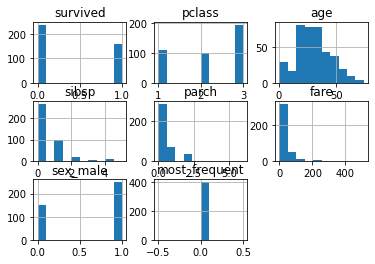

In [152]:
.hist()

array([[<AxesSubplot:title={'center':'survived'}>,
        <AxesSubplot:title={'center':'pclass'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'sibsp'}>,
        <AxesSubplot:title={'center':'parch'}>,
        <AxesSubplot:title={'center':'fare'}>],
       [<AxesSubplot:title={'center':'sex_male'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

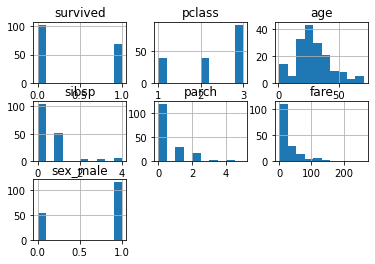

In [153]:
validate.hist()

array([[<AxesSubplot:title={'center':'survived'}>,
        <AxesSubplot:title={'center':'pclass'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'sibsp'}>,
        <AxesSubplot:title={'center':'parch'}>,
        <AxesSubplot:title={'center':'fare'}>],
       [<AxesSubplot:title={'center':'sex_male'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

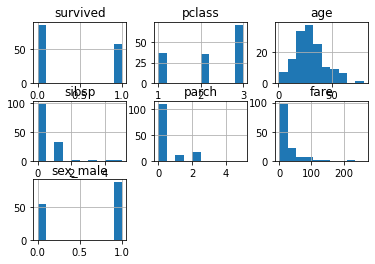

In [154]:
test.hist()